In [1]:
from model import RadarCamModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from nuscenes.utils.geometry_utils import view_points
import copy
import cv2

In [2]:
# Data location
PATH_IMAGE = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_im.jpg"
PATH_RELATIVE_DEPTHMAP = "/ssd/Datasets_and_code/nuscenes_depth_estimation/dataset/dataset_radar_cam/relative_depth/00100_rel_depth.npy"
PATH_RADAR = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_radar_pc.txt"
PATH_LIDAR = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_lidar_pc.txt"
PATH_CAM_MATRIX = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/test_data/00100_cam_matrix.txt"
MODEL_PATH = "/ssd/Datasets_and_code/nuscenes_depth_estimation/code/algorithm/results/2024-06-21_23-46-23/model_8.pth"

In [3]:
# MODEL PARAMETERS
W_ORIGINAL = 1600
H_ORIGINAL = 900
W_NN = 800
H_NN = 450
NUMBER_RADAR_POINTS = 100
MIN_DIST = 0.0
MAX_DIST = 50.0
RADAR_CHANNELS_ENCODER = [64, 128, 256, 432] 
UNET_CHANNELS_IMG = [2, 4, 8, 12, 16, 24, 32, 48] 
UNET_CHANNELS_RADAR = 24

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device: ", device)

model = RadarCamModel(RADAR_CHANNELS_ENCODER, UNET_CHANNELS_IMG, UNET_CHANNELS_RADAR).to(device)
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))

Using device:  cuda
mid channels:  40
mid channels:  8
mid channels:  8
mid channels:  4
mid channels:  4
mid channels:  4
mid channels:  2


<All keys matched successfully>

In [5]:
# Load data
rel_depth = np.load(PATH_RELATIVE_DEPTHMAP)
radar = np.loadtxt(PATH_RADAR)
lidar = np.loadtxt(PATH_LIDAR)
K = np.loadtxt(PATH_CAM_MATRIX)

In [6]:
# Adapt data

# Rel depthmap
rel_depth = resize(rel_depth, (H_NN, W_NN), order=1, preserve_range=True, anti_aliasing=False)
rel_depth = 1-rel_depth

# Radar
scale_factor_w = W_NN/W_ORIGINAL
scale_factor_h = H_NN/H_ORIGINAL
K[0][0] *= scale_factor_w
K[1][1] *= scale_factor_h
K[0][2] *= scale_factor_w
K[1][2] *= scale_factor_h

is_radar = True
for pc in [radar, lidar]:

    # Grab the depths (camera frame z axis points away from the camera).
    depths = pc[2, :]
    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc, K, normalize=True)
    # We change the third dimension (which is 1 after renormalization) to the depth
    points[2, :] = depths
    
    # Eliminate points outside the ranges
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > MIN_DIST)
    mask = np.logical_and(mask, depths < MAX_DIST)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < W_NN - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < H_NN - 1)
    points = points[:, mask]

    if is_radar:
        radar_projected = copy.deepcopy(points)

        points[0,:] /= W_NN
        points[1,:] /= H_NN
        points[2, :] = (points[2, :] - MIN_DIST) / (MAX_DIST - MIN_DIST)
        
        radar_adapted = points
        is_radar = False

    else:
        lidar_projected = copy.deepcopy(points)

# Now we resample the radar array to have fixed self.number_radar_points
num_points = radar_adapted.shape[1]
if num_points >= NUMBER_RADAR_POINTS:
    # If the initial pointcloud has more points, select target_size points without replacement
    selected_indices = np.random.choice(num_points, size=NUMBER_RADAR_POINTS, replace=False)
    radar_adapted = radar_adapted[:, selected_indices]
else:
    # If the initial pointcloud has less points, randomly sample with replacement until filling target_size
    selected_indices = np.random.choice(num_points, size=NUMBER_RADAR_POINTS - num_points, replace=True)
    radar_adapted = np.hstack([radar_adapted, radar_adapted[:, selected_indices]])

In [7]:
with torch.no_grad():
    # Perform inference
    rel_depth_torch, radar_adapted_torch = torch.from_numpy(rel_depth).to(device, dtype=torch.float), torch.from_numpy(radar_adapted).to(device, dtype=torch.float)
    rel_depth_torch = rel_depth_torch.unsqueeze(0).unsqueeze(0)
    radar_adapted_torch = radar_adapted_torch.unsqueeze(0)
    output = model(rel_depth_torch, radar_adapted_torch)
    output_cpu = output.cpu().squeeze()
    output_cpu = output_cpu * (MAX_DIST - MIN_DIST) + MIN_DIST
    

torch.Size([1, 1, 450, 800])
torch.Size([1, 2, 450, 800])
torch.Size([1, 4, 225, 400])
torch.Size([1, 8, 112, 200])
torch.Size([1, 12, 56, 100])
torch.Size([1, 16, 28, 50])
torch.Size([1, 24, 14, 25])
torch.Size([1, 32, 7, 12])
torch.Size([1, 48, 3, 6])
torch.Size([1, 72, 3, 6])
torch.Size([1, 32, 7, 12])
torch.Size([1, 24, 14, 25])
torch.Size([1, 16, 28, 50])
torch.Size([1, 12, 56, 100])
torch.Size([1, 8, 112, 200])
torch.Size([1, 4, 225, 400])
torch.Size([1, 2, 450, 800])
torch.Size([1, 1, 450, 800])


(-0.5, 799.5, 449.5, -0.5)

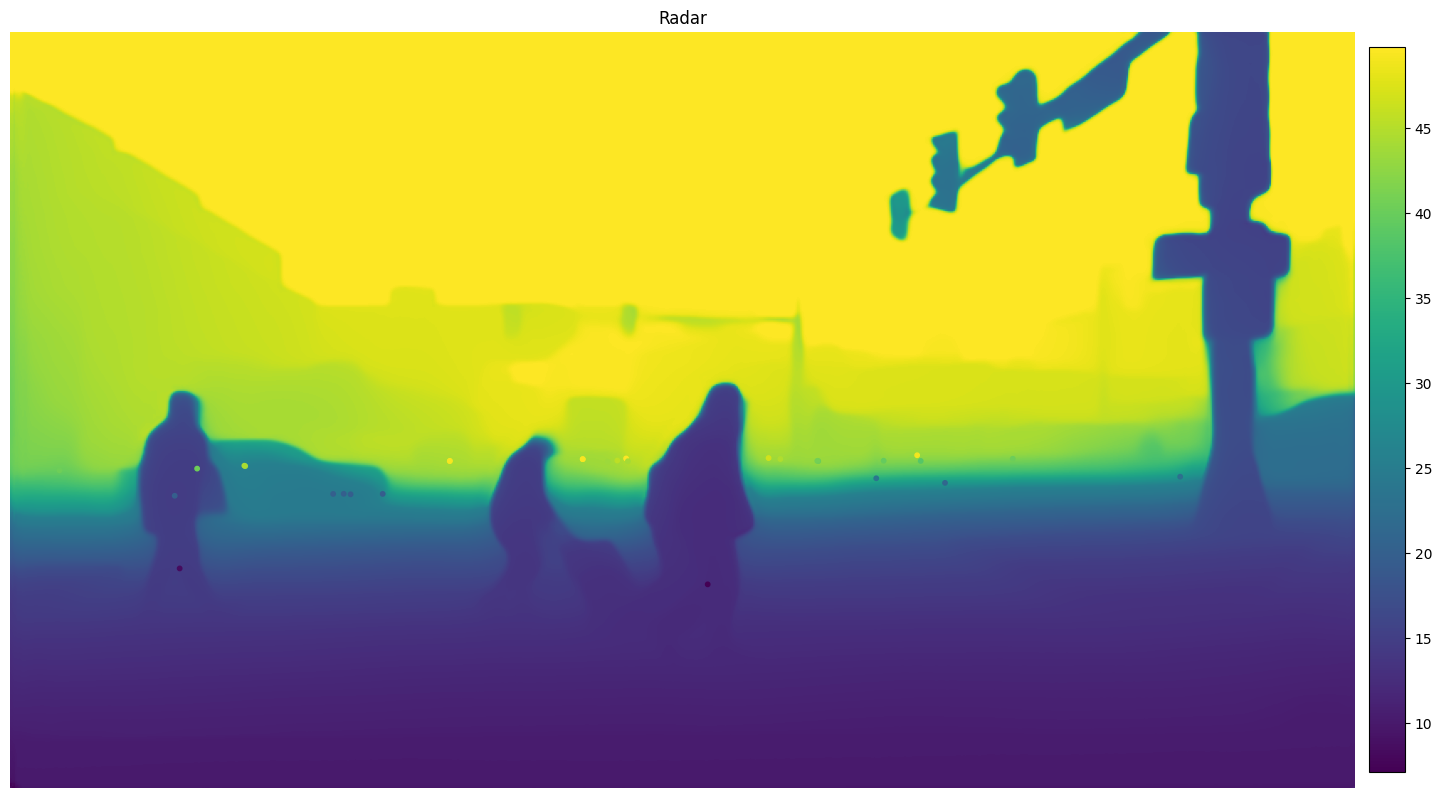

In [8]:
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(18, 32))
# Radar plot
ax.set_title('Radar')
radar_picture = ax.scatter(radar_projected[0,:], radar_projected[1,:], c=radar_projected[2,:], cmap='viridis', s=10)
fig.colorbar(radar_picture, ax=ax, fraction=0.026, pad=0.01)
ax.imshow(output_cpu, alpha=1.0, cmap='viridis')
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

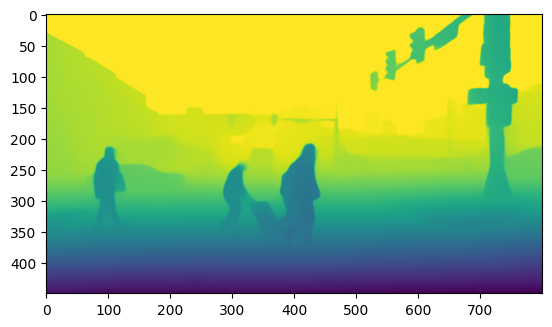

In [9]:
plt.imshow(rel_depth, cmap='viridis')

(-0.5, 799.5, 449.5, -0.5)

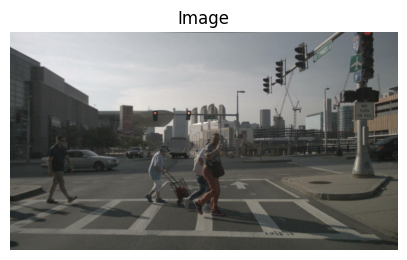

In [10]:
# PLOT IMAGE
image = cv2.imread(PATH_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (W_NN, H_NN))
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
# Radar plot
ax.set_title('Image')
ax.imshow(image, alpha=1.0)
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

(-0.5, 799.5, 449.5, -0.5)

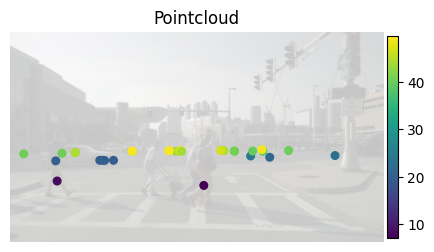

In [11]:
# PLOT POINTCLOUD
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
# Radar plot
ax.set_title('Pointcloud')
radar_picture = ax.scatter(radar_projected[0,:], radar_projected[1,:], c=radar_projected[2,:], cmap='viridis', s=30)
fig.colorbar(radar_picture, ax=ax, fraction=0.026, pad=0.01)
ax.imshow(image, alpha=0.25, cmap='viridis')
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

(-0.5, 799.5, 449.5, -0.5)

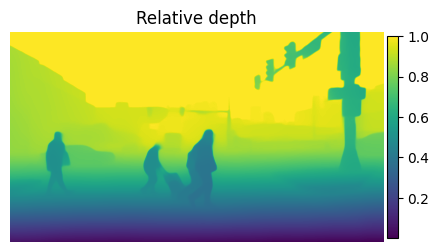

In [12]:
# PLOT RELATIVE DEPTHMAP
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
# Radar plot
ax.set_title('Relative depth')
plot_reldepth = ax.imshow(rel_depth, alpha=1.0)
fig.colorbar(plot_reldepth, ax=ax, fraction=0.026, pad=0.01)
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

(-0.5, 799.5, 449.5, -0.5)

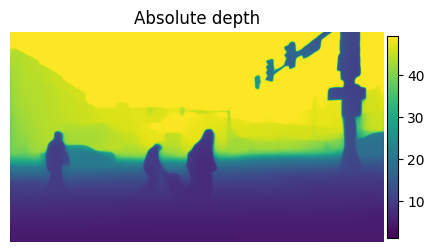

In [13]:
# PLOT RELATIVE DEPTHMAP
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
# Radar plot
ax.set_title('Absolute depth')
plot_absdepth = ax.imshow(output_cpu, alpha=1.0)
fig.colorbar(plot_absdepth, ax=ax, fraction=0.026, pad=0.01)
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

(-0.5, 799.5, 449.5, -0.5)

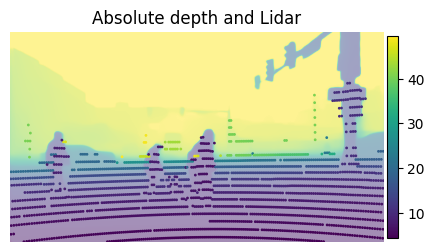

In [14]:
# Init axes.
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
# Radar plot
ax.set_title('Absolute depth and Lidar')
lidar_picture = ax.scatter(lidar_projected[0,:], lidar_projected[1,:], c=lidar_projected[2,:], cmap='viridis', s=1)
fig.colorbar(lidar_picture, ax=ax, fraction=0.026, pad=0.01)
ax.imshow(output_cpu, alpha=0.5, cmap='viridis')
ax.axis('off')
#ax[0].figure.colorbar(rel_depth, ax=ax[0], label='Depth')

In [15]:
print(model)

RadarCamModel(
  (radar_encoder): RadarEncoder(
    (conv_list): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
      (3): Conv1d(256, 432, kernel_size=(1,), stride=(1,))
    )
    (batchnorm_list): ModuleList(
      (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (unet): RadarCamUNet(
    (down_list): ModuleList(
      (0): Down(
        (maxpool_conv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): Ba